<a href="https://colab.research.google.com/github/Kadomium/Car_kit/blob/main/Car_kit_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [4]:
%pip install japanize-matplotlib
import japanize_matplotlib

In [5]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [6]:
#ここをサンプルのcdnoに
df_raw = pd.read_csv('/content/drive/MyDrive/Car-kit/carkit_100%.csv')
df_10 = pd.read_csv('/content/drive/MyDrive/Car-kit/carkit_edit.csv')
#df_raw = df_10.copy()
df = df_raw.copy()
df.head()

,key,qstrend,qxq999,qqkey,qs3,qxxx_1,qsk4_15,qsk4_1c,qsk4_2c,qs4_3,...,q57_117,q57_118,q57_2,q63,qxxx_10,qw3,qw7,qw11,qw5p,qw6
0,137000005,98,0.99600,6dcfd7121267effc8ba8a603233a6eace21ce331,2,NaN,1897,38,12,8,...,0,0,2,2,NaN,15,5,9400093,14,1
1,137000009,98,1.28326,2803263b7bbf69327e59981693d27af750dc7453,1,NaN,664,4,4,8,...,0,0,1,1,NaN,34,8,7310138,1,3
2,137000007,98,0.78118,c20af19f0e25d4cb7d2b9140930f1ae666315d61,3,NaN,1897,38,12,8,...,0,0,2,3,NaN,23,6,4410105,7,4
3,137000008,98,0.77699,3dfe5f849b7f9faa14c08dc1b48117745658d56d,1,NaN,227,1,1,5,...,0,0,1,3,NaN,14,4,2450063,13,3
4,137000010,98,0.65201,534a18a3770249dcaf5f358152648665217ef264,1,NaN,169,1,1,4,...,0,0,1,3,NaN,14,4,2470002,13,3


In [7]:
month_labels = {
    102: '21年12月',
    103: '22年1月',
    104: '22年2月',
    105: '22年3月',
    106: '22年4月',
    107: '22年5月',
    108: '22年6月',
    109: '22年7月',
    110: '22年8月',
    111: '22年9月',
    112: '22年10月',
    113: '22年11月',
    114: '22年12月',
    115: '23年1月',
    116: '23年2月',
    117: '23年3月',
    118: '23年4月',
    119: '23年5月',
    120: '23年6月',
    121: '23年7月',
    122: '23年8月',
    123: '23年9月',
    124: '23年10月',
    125: '23年11月',
    126: '23年12月',
    127: '24年1月',
    128: '24年2月',
    129: '24年3月',
    130: '24年4月',
    131: '24年5月',
    132: '24年6月',
    133: '24年7月',
    134: '24年8月',
    135: '24年9月',
    136: '24年10月',
    137: '24年11月',
    138: '24年12月'
}

# 1. dfからqsk4_15が426の行のみを抜き出してdf_boxと命名
df_box = df[df['qsk4_15'] == 426].copy()

# 2. qs4_4aの値ごとにサンプル数を集計
#    value_counts()で各値の出現回数を数え、sort_index()でqs4_4aの値（インデックス）で昇順に並べ替え
sample_counts_box = df_box['qs4_4a'].value_counts().sort_index()
sample_renamed_box = sample_counts_box.rename(index=month_labels)

# 1. dfからqsk4_15が426の行のみを抜き出してdf_boxと命名
df_custom = df[df['qsk4_15'] == 428].copy()

# 2. qs4_4aの値ごとにサンプル数を集計
#    value_counts()で各値の出現回数を数え、sort_index()でqs4_4aの値（インデックス）で昇順に並べ替え
sample_counts_custom = df_custom['qs4_4a'].value_counts().sort_index()
sample_renamed_custom = sample_counts_custom.rename(index=month_labels)

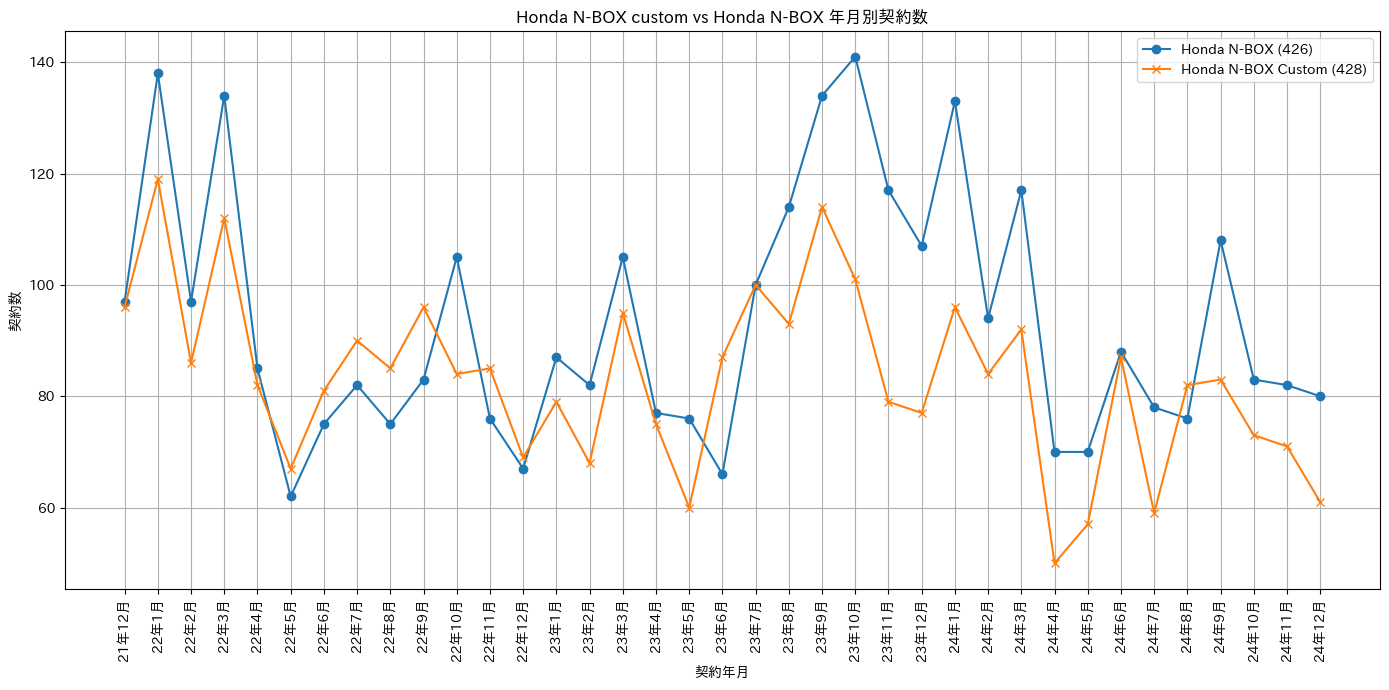

In [8]:
plt.figure(figsize=(14, 7))

# 2. 1つ目の折れ線グラフをプロット
plt.plot(
    sample_counts_custom.index,   # X軸：qs4_4aの値
    sample_counts_custom.values,  # Y軸：サンプル数
    marker='o',
    label='Honda N-BOX (426)'           # 凡例用のラベル
)

# 3. 2つ目の折れ線グラフをプロット
plt.plot(
    sample_counts_box.index,   # X軸：qs4_4aの値
    sample_counts_box.values,  # Y軸：サンプル数（元のコードのtypoを修正）
    marker='x',                # マーカーを変えて見やすくする
    label='Honda N-BOX Custom (428)'    # 凡例用のラベル
)

# 4. グラフ全体のタイトルやラベルを設定
plt.title('Honda N-BOX custom vs Honda N-BOX 年月別契約数')
plt.xlabel('契約年月')
plt.ylabel('契約数')
plt.grid(True)
plt.legend()  # labelで指定した凡例を表示

# 5. X軸の目盛りを両方のデータに合わせて設定
#   両方のデータのインデックス(qs4_4aの値)を結合し、重複を除いてソート
all_xticks = sorted(list(set(sample_counts_custom.index) | set(sample_counts_box.index)))
#   month_labels辞書を使って、数値のインデックスを年月ラベルに変換
xtick_labels = [month_labels.get(x, x) for x in all_xticks] # 辞書にないキーの場合は元の数値を表示

plt.xticks(ticks=all_xticks, labels=xtick_labels, rotation=90)

# グラフ下部の余白を調整して、回転したラベルが見切れないようにする
plt.tight_layout()

plt.savefig("n_box_custom_compare_month.png", dpi=300)

# 6. グラフを表示
plt.show()

In [9]:
df.isnull().sum(axis=1)

,0
0,500
1,369
2,487
3,476
4,478
...,...
120695,473
120696,385
120697,463
120698,137


In [10]:
# とりあえずnullが1%以上の列は明らかに不要だから消しちゃう(df_cleaned)
# 後々0.4以上にして欠損値補完をするのもいい(プランB)
nan_ratio = df.isnull().sum() / len(df)
cols_to_drop = nan_ratio[nan_ratio > 0.01].index

df_cleaned = df.drop(columns=cols_to_drop)
#2回目の洗浄、列指定でデータリークやIDを消していく

all_columns_to_drop = ['key', 'qqkey', 'qxq999','qs3','qsk4_15','qsk4_1c','qsk4_2c','qs4_3','qs4_8a','qs4_9','qs4_10','qs4_11','qs4_12','qs4_13','qsq4_gas','qskei_1','qskei_2','qsnou_1','qsnou_2','qsq2','q6_2','q6_4','q6_5_31','q6_5_32','q6_5_33','q6_5_34','q6_5_35','q6_5_36','q6_5_37','q6_5_38','q6_5_39','q6_5_310','q6_5_311','q6_5_312','q6_5_313','q6_5_314','q6_5_315','q6_5_316','q6_5_317','q6_5_318','q6_5_319','q6_5_320','q6_5_321','q6_5_41','q6_5_42','q6_5_43','q6_5_44','q6_5_45','q6_5_46','q6_5_47','q6_5_48','q6_5_49','q6_5_410','q6_5_411','q6_5_412','q6_5_413','q6_5_414','q6_5_415','q6_5_416','q6_5_417','q6_5_418','q6_5_419','q6_5_420','q6_5_421','q6_5_51','q6_5_52','q6_5_53','q6_5_54','q6_5_55','q6_5_56','q6_5_57','q6_5_58','q6_5_59','q6_5_510','q6_5_511','q6_5_512','q6_5_513','q6_5_514','q6_5_515','q6_5_516','q6_5_517','q6_5_518','q6_5_519','q6_5_520','q6_5_521','q6_5_61','q6_5_62','q6_5_63','q6_5_64','q6_5_65','q6_5_66','q6_5_67','q6_5_68','q6_5_69','q6_5_610','q6_5_611','q6_5_612','q6_5_613','q6_5_614','q6_5_615','q6_5_616','q6_5_617','q6_5_618','q6_5_619','q6_5_620','q6_5_621','q9_2','q13_11','q13_12','q13_13','q13_14','q13_15','q13_16','q13_17','q13_18','q13_19','q13_110','q13_111','q13_112','q13_113','q13_114','q13_115','q13_116','q13_117','q13_118','q13_119','q13_120','q13_121','q13_122','q13_123','q13_124','q13_125','q13_126','q13_127','q13_128','q13_2','q14_2','q57_2','q63','rand_id']

existing_columns_to_drop = [col for col in all_columns_to_drop if col in df.columns]

df_cleaned = df_cleaned.drop(columns=existing_columns_to_drop, inplace=True)

In [11]:
# 1. 各列のnullの数を計算
nan_counts = df_cleaned.isnull().sum()

# 2. nullの数を降順でソートして表示
print("--- 各列のNullの数（降順） ---")
print(nan_counts.sort_values(ascending=False))

# 3. データ総数に対するnullの割合を計算して表示
total_rows = len(df_cleaned)
nan_ratio = (df_cleaned.isnull().sum() / total_rows) * 100
print("\n--- 各列のNullの割合（%） ---")
print(nan_ratio.sort_values(ascending=False))

--- 各列のNullの数（降順） ---
qw6         0
qstrend     0
qs3         0
qsk4_15     0
qsk4_1c     0
           ..
qsnou_1     0
qskei_2     0
qskei_1     0
qs4_4a      0
qsq4_gas    0
Length: 1036, dtype: int64

--- 各列のNullの割合（%） ---
qw6         0.0
qstrend     0.0
qs3         0.0
qsk4_15     0.0
qsk4_1c     0.0
           ... 
qsnou_1     0.0
qskei_2     0.0
qskei_1     0.0
qs4_4a      0.0
qsq4_gas    0.0
Length: 1036, dtype: float64


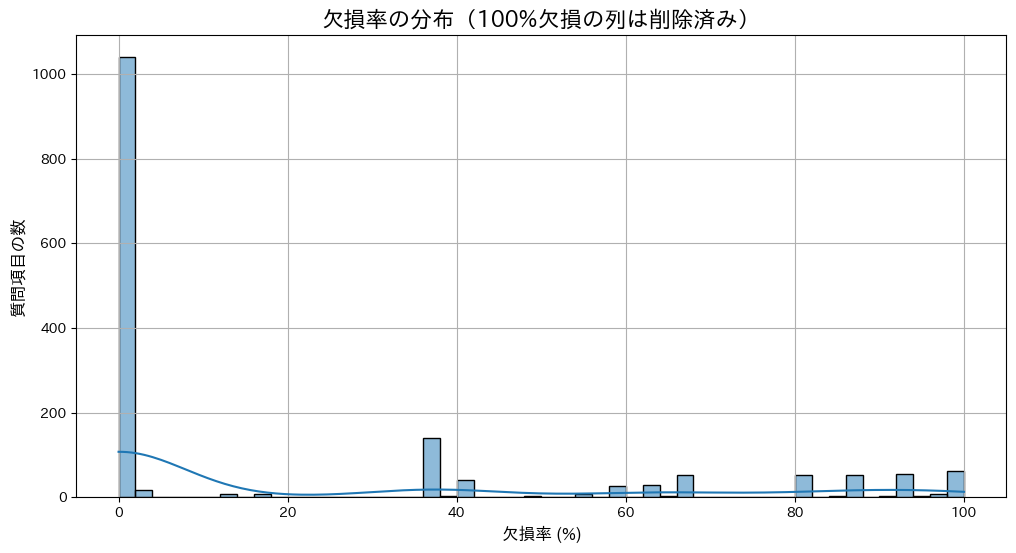

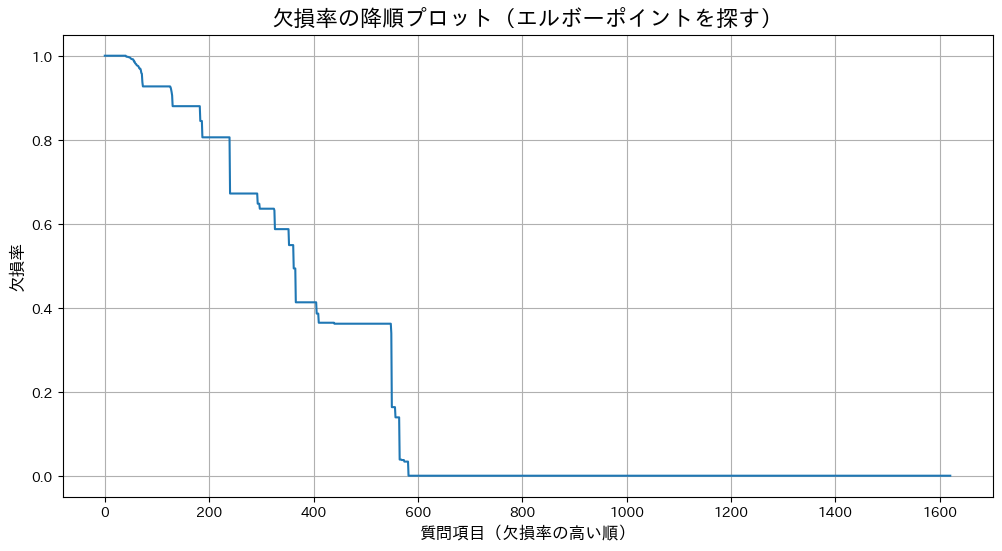

In [12]:
# 残った列で再度、欠損率を計算
nan_ratio = df_raw.isnull().sum() / len(df_raw)

# 可視化1: ヒストグラムで欠損率の分布を見る
plt.figure(figsize=(12, 6))
sns.histplot(nan_ratio * 100, bins=50, kde=True)
plt.title('欠損率の分布（100%欠損の列は削除済み）', fontsize=16)
plt.xlabel('欠損率 (%)', fontsize=12)
plt.ylabel('質問項目の数', fontsize=12)
plt.grid(True)
plt.savefig("null_hist.png", dpi=300, bbox_inches='tight')
plt.show()

# 可視化2: 欠損率を降順にソートした棒グラフで見る
plt.figure(figsize=(12, 6))
nan_ratio.sort_values(ascending=False).plot(kind='line', use_index=False)
plt.title('欠損率の降順プロット（エルボーポイントを探す）', fontsize=16)
plt.xlabel('質問項目（欠損率の高い順）', fontsize=12)
plt.ylabel('欠損率', fontsize=12)
plt.grid(True)
plt.savefig("null_elbow.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
df_cleaned.head()

,qstrend,qs3,qsk4_15,qsk4_1c,qsk4_2c,qs4_3,qs4_8a,qs4_9,qs4_10,qs4_11,...,q57_116,q57_117,q57_118,q57_2,q63,qw3,qw7,qw11,qw5p,qw6
0,98,2,1897,38,12,8,2,1,1,2,...,0,0,0,2,2,15,5,9400093,14,1
1,98,1,664,4,4,8,7,2,1,1,...,0,0,0,1,1,34,8,7310138,1,3
2,98,3,1897,38,12,8,2,1,1,2,...,0,0,0,2,3,23,6,4410105,7,4
3,98,1,227,1,1,5,3,2,1,2,...,0,0,0,1,3,14,4,2450063,13,3
4,98,1,169,1,1,4,7,2,1,2,...,0,0,0,1,3,14,4,2470002,13,3


In [14]:
month_labels = {
    102: '21年12月',
    103: '22年1月',
    104: '22年2月',
    105: '22年3月',
    106: '22年4月',
    107: '22年5月',
    108: '22年6月',
    109: '22年7月',
    110: '22年8月',
    111: '22年9月',
    112: '22年10月',
    113: '22年11月',
    114: '22年12月',
    115: '23年1月',
    116: '23年2月',
    117: '23年3月',
    118: '23年4月',
    119: '23年5月',
    120: '23年6月',
    121: '23年7月',
    122: '23年8月',
    123: '23年9月',
    124: '23年10月',
    125: '23年11月',
    126: '23年12月',
    127: '24年1月',
    128: '24年2月',
    129: '24年3月',
    130: '24年4月',
    131: '24年5月',
    132: '24年6月',
    133: '24年7月',
    134: '24年8月',
    135: '24年9月',
    136: '24年10月',
    137: '24年11月',
    138: '24年12月'
}

In [15]:
# --- Step 1: 時間コードと実際の年月を対応付ける辞書を作成 ---
# このマッピングを37ヶ月分作成します
start_year = 2021
start_month = 12
time_map = {}
for i in range(37):
    current_year = start_year + (start_month + i - 1) // 12
    current_month = (start_month + i - 1) % 12 + 1

    time_code = 102 + i
    date_str = f"{current_year}-{current_month:02d}" # '2022-01' のように0埋めする

    time_map[time_code] = date_str

# --- Step 2: 辞書を使って 'qs4_4a'列を置換（マッピング） ---
# .map()メソッドを使うのが最も簡単で効率的です
df_cleaned['date_str'] = df_cleaned['qs4_4a'].map(time_map)

# --- Step 3: 【最重要】文字列をPandasのdatetime型（月末実績値）に変換 ---
df_cleaned['date'] = pd.to_datetime(df_cleaned['date_str']).dt.to_period('M').dt.to_timestamp('M')

# --- Step 4: datetime型の列をデータフレームのインデックスに設定 ---
# これにより、データが正式に時系列データとして扱われます
df_cleaned.set_index('date', inplace=True)

# 元の不要になった列は削除して整理
df_cleaned.drop(['qs4_4a', 'date_str'], axis=1, inplace=True)

print("\n--- 最終的な時系列データフレーム ---")
print(df_cleaned.head())
print("\nインデックスの型:")
print(type(df_cleaned.index))


--- 最終的な時系列データフレーム ---
            qstrend  qs3  qsk4_15  qsk4_1c  qsk4_2c  qs4_3  qs4_8a  qs4_9  \
date                                                                        
2021-12-31       98    2     1897       38       12      8       2      1   
2021-12-31       98    1      664        4        4      8       7      2   
2021-12-31       98    3     1897       38       12      8       2      1   
2021-12-31       98    1      227        1        1      5       3      2   
2021-12-31       98    1      169        1        1      4       7      2   

            qs4_10  qs4_11  ...  q57_116  q57_117  q57_118  q57_2  q63  qw3  \
date                        ...                                               
2021-12-31       1       2  ...        0        0        0      2    2   15   
2021-12-31       1       1  ...        0        0        0      1    1   34   
2021-12-31       1       2  ...        0        0        0      2    3   23   
2021-12-31       1       2  ...        0 

In [16]:
# 1. 表示する最大の列数を設定（Noneで無制限）
pd.set_option('display.max_columns', None)

# 2. (任意) 表示する最大の行数を設定（Noneで無制限）
pd.set_option('display.max_rows', None)

# 3. (任意) 表示する際の幅を設定（折り返しを防ぐ）
pd.set_option('display.width', 2000) # 数値はご自身の画面幅に合わせて調整してください

# これで、df.columns を表示すると...
print("--- df_cleaned.columns の全表示 ---")
print(df_cleaned.columns)

# データフレームの先頭を表示しても、列が省略されなくなります
print("\n--- df_cleaned.head() の全列表示 ---")
print(df_cleaned.head())

--- df_cleaned.columns の全表示 ---
Index(['qstrend', 'qs3', 'qsk4_15', 'qsk4_1c', 'qsk4_2c', 'qs4_3', 'qs4_8a', 'qs4_9', 'qs4_10', 'qs4_11',
       ...
       'q57_116', 'q57_117', 'q57_118', 'q57_2', 'q63', 'qw3', 'qw7', 'qw11', 'qw5p', 'qw6'], dtype='object', length=1035)

--- df_cleaned.head() の全列表示 ---
            qstrend  qs3  qsk4_15  qsk4_1c  qsk4_2c  qs4_3  qs4_8a  qs4_9  qs4_10  qs4_11  qs4_12  qs4_13  qsq4_gas  qskei_1  qskei_2  qsnou_1  qsnou_2  qs7  qs7_2  qs8  qs8_2  qs9  qs18  qs19  qsq2  q6_2  q6_4  q6_5_31  q6_5_32  q6_5_33  q6_5_34  q6_5_35  q6_5_36  q6_5_37  q6_5_38  q6_5_39  q6_5_310  q6_5_311  q6_5_312  q6_5_313  q6_5_314  q6_5_315  q6_5_316  q6_5_317  q6_5_318  q6_5_319  q6_5_320  q6_5_321  q6_5_41  q6_5_42  q6_5_43  q6_5_44  q6_5_45  q6_5_46  q6_5_47  q6_5_48  q6_5_49  q6_5_410  q6_5_411  q6_5_412  q6_5_413  q6_5_414  q6_5_415  q6_5_416  q6_5_417  q6_5_418  q6_5_419  q6_5_420  q6_5_421  q6_5_51  q6_5_52  q6_5_53  q6_5_54  q6_5_55  q6_5_56  q6_5_57  q6_5_58  q6_5_59  

In [17]:
output_filename = 'column_names.txt'

with open(output_filename, 'w') as f:
    for col_name in df_cleaned.columns:
        f.write(f"{col_name}\n")

print(f"全ての列名を '{output_filename}' に保存しました。")

全ての列名を 'column_names.txt' に保存しました。
